# The QR Decomposition For Regression Models

### Aravind S

### 03 Sep 2017

### Content of this notebook is wholly derived from the original R notebook by Michael Betancourt (http://mc-stan.org/users/documentation/case-studies/qr_regression.html). Only the code has been translated from R to Python

A common problem in regression modeling is correlation amongst the covariates
which can induce strong posterior correlations that frustrate accurate
computation.  In this case study I will review the  _QR decomposition_, a
technique for decorrelating covariates and, consequently, the resulting
posterior distribution.  

We'll begin with a simple example that demonstrates the difficulties induced
by correlated covariates before going through the mathematics of the QR
decomposition and finally how it can be applied in Stan.


### Setting up the Python Environment & Helper functions

First things first, let's setup our local environment along with utility functions,

The following cell will install and load the helper stanmagic extension to write/compile stan code within a jupyter code cell (rather than having a seperate stan file or within python strings). If you __really__ don't want to install it, the stan files are saved within my repository, so you can skip running or delete the %%stan cells in this notebook (it will not affect the output in any way)

In [1]:
!pip install git+https://github.com/Arvinds-ds/stanmagic.git
%load_ext stanmagic

  Cloning https://github.com/Arvinds-ds/stanmagic.git to /tmp/pip-oqw_78_l-build


In [2]:
from __future__ import print_function, division
import pystan
import numpy as np
import scipy
import scipy.stats as stats
from collections import OrderedDict
import matplotlib.pyplot as plt

%matplotlib inline

import warnings; warnings.simplefilter('ignore')

plt.rcParams['figure.figsize'] = [12,10]
plt.style.use('seaborn-darkgrid')

c_light = "#DCBCBC"
c_light_highlight = "#C79999"
c_mid = "#B97C7C"
c_mid_highlight= "#A25050"
c_dark = "#8F2727"
c_dark_highlight ="#7C0000"

c_light_trans = "#DCBCBC80"
c_light_highlight_trans = "#C7999980"
c_mid_trans = "#B97C7C80"
c_mid_highlight_trans = "#A2505080"
c_dark_trans = "#8F272780"
c_dark_highlight_trans = "#7C000080"

In [3]:
## Stan Utility functions (Python Code Courtesy: Michael Betancourt)
def check_div(fit):
    """Check transitions that ended with a divergence"""
    sampler_params = fit.get_sampler_params(inc_warmup=False)
    divergent = [x for y in sampler_params for x in y['divergent__']]
    n = sum(divergent)
    N = len(divergent)
    print('{} of {} iterations ended with a divergence ({}%)'.format(n, N,
            100 * n / N))
    if n > 0:
        print('Try running with larger adapt_delta to remove the divergences')

def check_treedepth(fit, max_depth = 10):
    """Check transitions that ended prematurely due to maximum tree depth limit"""
    sampler_params = fit.get_sampler_params(inc_warmup=False)
    depths = [x for y in sampler_params for x in y['treedepth__']]
    n = sum(1 for x in depths if x == max_depth)
    N = len(depths)
    print(('{} of {} iterations saturated the maximum tree depth of {}'
            + ' ({}%)').format(n, N, max_depth, 100 * n / N))
    if n > 0:
        print('Run again with max_depth set to a larger value to avoid saturation')

def check_energy(fit):
    """Checks the energy Bayesian fraction of missing information (E-BFMI)"""
    sampler_params = fit.get_sampler_params(inc_warmup=False)
    for chain_num, s in enumerate(sampler_params):
        energies = s['energy__']
        numer = sum((energies[i] - energies[i - 1])**2 for i in range(1, len(energies))) / len(energies)
        denom = np.var(energies)
        if numer / denom < 0.2:
            print('Chain {}: E-BFMI = {}'.format(chain_num, numer / denom))
            print('E-BFMI below 0.2 indicates you may need to reparameterize your model')

def _by_chain(unpermuted_extraction):
    num_chains = len(unpermuted_extraction[0])
    result = [[] for _ in range(num_chains)]
    for c in range(num_chains):
        for i in range(len(unpermuted_extraction)):
            result[c].append(unpermuted_extraction[i][c])
    return np.array(result)

def _shaped_ordered_params(fit):
    ef = fit.extract(permuted=False, inc_warmup=False) # flattened, unpermuted, by (iteration, chain)
    ef = _by_chain(ef)
    ef = ef.reshape(-1, len(ef[0][0]))
    ef = ef[:, 0:len(fit.flatnames)] # drop lp__
    shaped = {}
    idx = 0
    for dim, param_name in zip(fit.par_dims, fit.extract().keys()):
        length = int(np.prod(dim))
        shaped[param_name] = ef[:,idx:idx + length]
        shaped[param_name].reshape(*([-1] + dim))
        idx += length
    return shaped

def partition_div(fit):
    """ Returns parameter arrays separated into divergent and non-divergent transitions"""
    sampler_params = fit.get_sampler_params(inc_warmup=False)
    div = np.concatenate([x['divergent__'] for x in sampler_params]).astype('int')
    params = _shaped_ordered_params(fit)
    nondiv_params = dict((key, params[key][div == 0]) for key in params)
    div_params = dict((key, params[key][div == 1]) for key in params)
    return nondiv_params, div_params

## Fitting Issues with Correlated Covariates

Now consider a very simple regression with only two covariates --
$x \sim \mathcal{N} (1, 0.1)$ and it's square, $x^{2}$. The inclusion of both
$x$ and $x^{2}$ is not uncommon in polynomial regressions where the response is
given by a sum of polynomials over the input covariates.

In particular, the correlations here are particularly strong because we didn't
standardize the covariate, $x$, before squaring it.  Powers are much better
identified when the input is centered around zero.  Unfortunately in practice
we may not be able to standardize the covariates before they are transformed.
Moreover, in more complex regressions seemingly independent covariates are
often highly correlated due to common confounders in which case standardization
will not be of much help.

We begin by simulating some data


In [4]:
np.random.seed(2481)

N  =  5000
x =  stats.norm(loc=10, scale=1).rvs(N)
X = np.c_[x,x**2].T

M = 2
beta = np.array([[2.5],[-1]])
alpha = -0.275
sigma = 0.8

mu = np.dot(X.T, beta) + alpha
y = np.squeeze(stats.norm(loc=mu, scale=sigma).rvs())

data = OrderedDict({'N': N, 'M': M, 'X':X, 'y':y})

Because the covariate $x$ is restricted to positive values, it is highly
correlated with its square,

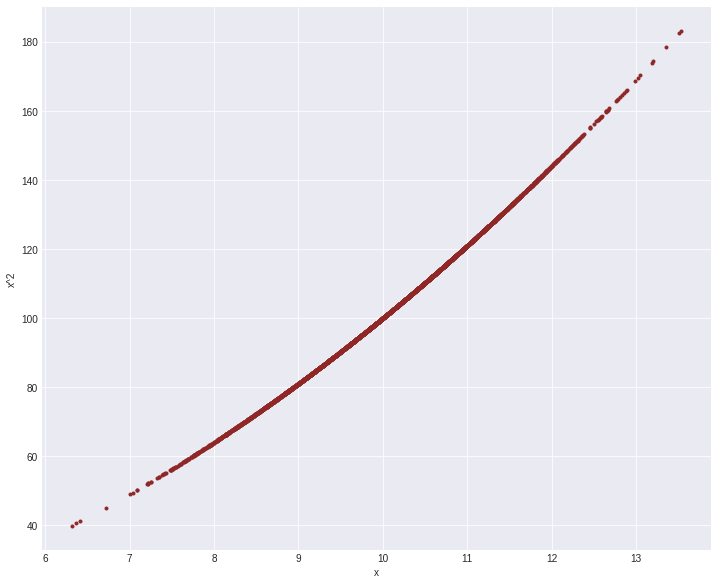

In [5]:
plt.plot(X[0,:],X[1,:],'.',c=c_dark)
plt.xlabel('x')
plt.ylabel('x^2')

With the data in hand we can attempt to fit a naive linear regression model,

In [6]:
%%stan -f regr.stan

data {
  int<lower=1> N;
  int<lower=1> M;
  matrix[M, N] X;
  vector[N] y;
}

parameters {
  vector[M] beta;
  real alpha;
  real<lower=0> sigma;
}

model {
  beta ~ normal(0, 10);
  alpha ~ normal(0, 10);
  sigma ~ cauchy(0, 10);

  y ~ normal(X' * beta + alpha, sigma);
}



Using pystan.stanc compiler..
-------------------------------------------------------------------------------
Model compiled successfully. Output stored in _stan_model object.
Type _stan_model in a cell to see a nicely formatted code output in a notebook
     ^^^^^^^^^^^
Access model compile output properties
_stan_model.model_file -> Name of stan_file [regr.stan]
_stan_model.model_name -> Name of stan model [regr_model]
_stan_model.model_code -> Model code [ data {   int<lower= ....]


In [7]:
model = pystan.StanModel(file='regr.stan')
fit = model.sampling(data=data, seed=42)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_56ca276e23b83377730a795fa0a95b5a NOW.


Checking our diagnostics,

In [8]:
print(fit)

Inference for Stan model: anon_model_56ca276e23b83377730a795fa0a95b5a.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

          mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
beta[0]   2.26  5.8e-3   0.16   1.96   2.15   2.26   2.37   2.58    768    1.0
beta[1]  -0.99  2.9e-4 8.1e-3   -1.0  -0.99  -0.99  -0.98  -0.97    765    1.0
alpha     0.89    0.03    0.8  -0.71   0.36    0.9   1.43    2.4    779    1.0
sigma     0.79  2.9e-4 8.1e-3   0.78   0.79   0.79    0.8   0.81    779    1.0
lp__     -1344    0.04   1.42  -1348  -1345  -1344  -1343  -1342   1071    1.0

Samples were drawn using NUTS at Mon Sep 11 20:22:39 2017.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


In [9]:
check_treedepth(fit)

234 of 4000 iterations saturated the maximum tree depth of 10 (5.85%)
Run again with max_depth set to a larger value to avoid saturation


In [10]:
check_energy(fit)
check_div(fit)

0.0 of 4000 iterations ended with a divergence (0.0%)


we see that everything looks okay save for some trajectories that have
prematurely terminated because of the default tree depth limit.  Although there
aren't many of them,

(array([   13.,   189.,    83.,   167.,   326.,   535.,   438.,   789.,
         1226.,   234.]),
 array([  1. ,   1.9,   2.8,   3.7,   4.6,   5.5,   6.4,   7.3,   8.2,
          9.1,  10. ]),
 <a list of 10 Patch objects>)

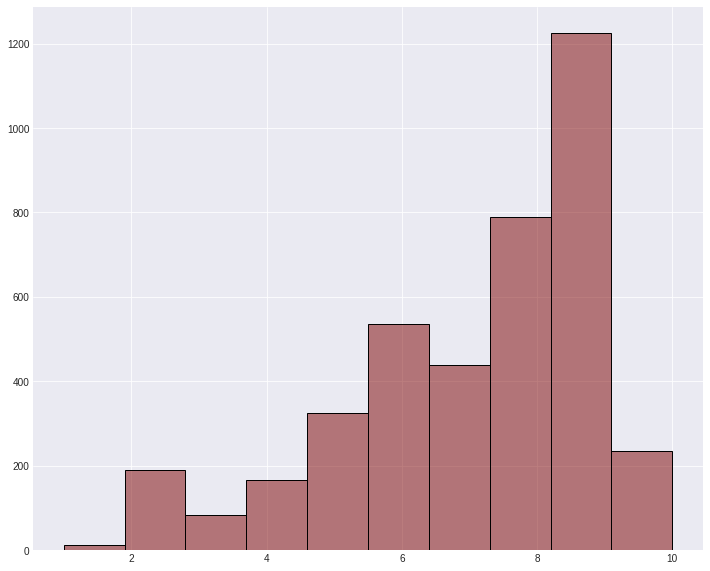

In [11]:
treedepths = np.concatenate([fit.get_sampler_params(inc_warmup=False)[i]['treedepth__'] for i in range(4)])
plt.hist(treedepths,color=c_dark_highlight_trans,edgecolor='k')

even a few prematurely terminating trajectories can hinder performance, and
may even indicate potential problems with adaptation.

To maximize performance and avoid any potential issues we refit with a larger
tree depth threshold,

In [12]:
fit = model.sampling(data=data, seed=42,control={'max_treedepth':15})

Now the diagnostics are clean

In [13]:
print(fit)

Inference for Stan model: anon_model_56ca276e23b83377730a795fa0a95b5a.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

          mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
beta[0]   2.26  5.9e-3   0.15   1.96   2.15   2.25   2.36   2.56    679   1.01
beta[1]  -0.99  3.0e-4 7.7e-3   -1.0  -0.99  -0.99  -0.98  -0.97    683   1.01
alpha     0.91    0.03   0.77  -0.56   0.41   0.92   1.43   2.41    682   1.01
sigma     0.79  2.2e-4 7.7e-3   0.78   0.79   0.79    0.8   0.81   1256    1.0
lp__     -1344    0.04    1.4  -1347  -1345  -1344  -1343  -1342   1086    1.0

Samples were drawn using NUTS at Mon Sep 11 20:28:15 2017.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


In [14]:
check_treedepth(fit, 15)

0 of 4000 iterations saturated the maximum tree depth of 15 (0.0%)


In [15]:
check_energy(fit)
check_div(fit)

0.0 of 4000 iterations ended with a divergence (0.0%)


The small step sizes, however,

In [16]:
stepsizes = [fit.get_sampler_params(inc_warmup=False)[i]['stepsize__'][0] for i in range(4)]
print(*["Chain " + str(i) + " "*10 for i in range(1,5)])
print(*(stepsizes))

Chain 1           Chain 2           Chain 3           Chain 4          
0.00633081398773 0.00556104827827 0.00513452099165 0.00535896040473


do require significant computation, over one million gradient evaluations,
across the entire fit,

In [17]:
n_gradients = [np.sum(fit.get_sampler_params(inc_warmup=False)[i]['n_leapfrog__']) for i in range(4)]
n_gradients

[336034.0, 365166.0, 374312.0, 387486.0]

In [18]:
sum(n_gradients)

1462998.0

Plotting the posterior samples we can see why.  The marginal posterior for the
slopes is only weakly-identified and the posterior geometry becomes extremely
narrow,

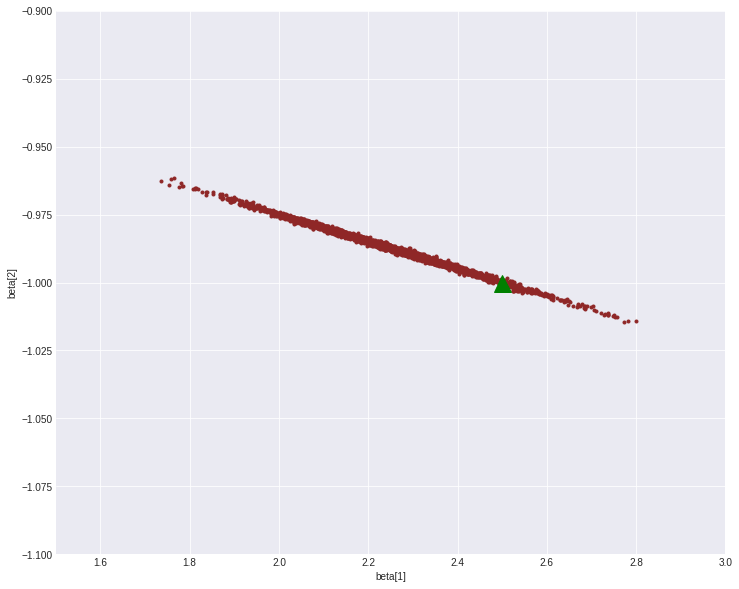

In [19]:
partition = partition_div(fit)
params = partition[0]
ax = plt.subplot(111)
ax.set_xlim([1.5,3])
ax.set_ylim([-1.1,-0.9])
ax.plot(params['beta'][:,0], params['beta'][:,1],'.', color=c_dark,)
ax.plot(beta[0,0], beta[1,0],'^',color='green', markersize=17)
ax.set_ylabel('beta[2]')
ax.set_xlabel('beta[1]')

requiring very precise trajectory simulations at each iteration of the Markov
chains.

## Decorrelating the Posterior with a QR Decomposition

Fortunately we can reduce the correlations between the covariates, and
ameliorate the challenging geometry of the Bayesian posterior, by applying a QR
decomposition.  Perhaps unsurprisingly this is the same QR decomposition that
arises in the analytic maximum likelihood and conjugate Bayesian treatment of
linear regression, although here it will be applicable regardless of the choice
of priors and for any general linear model.

### Mathematical Derivation

The _thin_ QR decomposition decomposes a rectangular $N \times M$ matrix
into
$$
\mathbf{A} = \mathbf{Q} \cdot \mathbf{R}
$$
where $\mathbf{Q}$ is an $N \times M$ orthogonal matrix with $M$ non-zero rows
and $N - M$ rows of vanishing rows, and $\mathbf{R}$ is a $M \times M$
upper-triangular matrix.

If we apply the decomposition to the transposed design matrix,
$\mathbf{X}^{T} = \mathbf{Q} \cdot \mathbf{R}$, then we can refactor the linear
response as
$$
\begin{align*}
\boldsymbol{\mu}
&= \mathbf{X}^{T} \cdot \boldsymbol{\beta} + \alpha
\\
&= \mathbf{Q} \cdot \mathbf{R} \cdot \boldsymbol{\beta} + \alpha
\\
&= \mathbf{Q} \cdot (\mathbf{R} \cdot \boldsymbol{\beta}) + \alpha
\\
&= \mathbf{Q} \cdot \widetilde{\boldsymbol{\beta}} + \alpha.
\\
\end{align*}
$$

Because the matrix $\mathbf{Q}$ is orthogonal, its columns are independent and
consequently we expect the posterior over the new parameters,
$\widetilde{\boldsymbol{\beta}} = \mathbf{R} \cdot \boldsymbol{\beta}$,
to be significantly less correlated.  In practice we can also equalize the
scales of the posterior by normalizing the $Q$ and $R$ matrices,
$$
\begin{align*}
\mathbf{Q} &\rightarrow \mathbf{Q} \cdot N
\\
\mathbf{R} &\rightarrow \mathbf{R} \, / \, N.
\end{align*}
$$

We can then readily recover the original slopes as
$$
\boldsymbol{\beta} = \mathbf{R}^{-1} \cdot \widetilde{\boldsymbol{\beta}}.
$$
As $\mathbf{R}$ is upper diagonal we could compute its inverse with only
$\mathcal{O} (M^{2})$ operations, but because we need to compute it only once
we will use the naive inversion function in Stan here.

Because the transformation between $\boldsymbol{\beta}$ and
$\widetilde{\boldsymbol{\beta}}$ is _linear_, the corresponding Jacobian depends
only on the data and hence doesn't affect posterior computations.  This means
that in Stan we can define the transformed parameters
$\boldsymbol{\beta} = \mathbf{R}^{-1} \cdot \widetilde{\boldsymbol{\beta}}$
and apply priors directly to $\boldsymbol{\beta}$ while ignoring the warning
about Jacobians.

Interestingly, applying weakly-informative priors to the
$\widetilde{\boldsymbol{\beta}}$ directly can be interpreted as a form
of _empirical Bayes_, where we use the empirical correlations in the data to
guide the choice of prior.

### Implementation in Stan

The scaled, thin QR decomposition is straightforward to implement in Stan,

In [20]:
%%stan -f qr_regr.stan

data {
  int<lower=1> N;
  int<lower=1> M;
  matrix[M, N] X;
  vector[N] y;
}

transformed data {
  // Compute, thin, and then scale QR decomposition
  matrix[N, M] Q = qr_Q(X')[, 1:M] * N;
  matrix[M, M] R = qr_R(X')[1:M, ] / N;
  matrix[M, M] R_inv = inverse(R);
}

parameters {
  vector[M] beta_tilde;
  real alpha;
  real<lower=0> sigma;
}

transformed parameters {
  vector[M] beta = R_inv * beta_tilde;
}

model {
  beta ~ normal(0, 10);
  alpha ~ normal(0, 10);
  sigma ~ cauchy(0, 10);

  y ~ normal(Q * beta_tilde + alpha, sigma);
}

Using pystan.stanc compiler..
-------------------------------------------------------------------------------
Model compiled successfully. Output stored in _stan_model object.
Type _stan_model in a cell to see a nicely formatted code output in a notebook
     ^^^^^^^^^^^
Access model compile output properties
_stan_model.model_file -> Name of stan_file [qr_regr.stan]
_stan_model.model_name -> Name of stan model [qr_regr_model]
_stan_model.model_code -> Model code [ data {   int<lower= ....]


Fitting the QR regression model, and ignoring the warning about the Jacobian
due to the considerations above,

In [21]:
qr_model = pystan.StanModel(file='qr_regr.stan')
qr_fit = qr_model.sampling(data=data, seed=42)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_526df9e83c403034ce9097d4b0542795 NOW.


we see no indications of an inaccurate fit,

In [22]:
qr_fit

Inference for Stan model: anon_model_526df9e83c403034ce9097d4b0542795.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

                mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
beta_tilde[0]  -1.11  3.9e-4   0.01  -1.13  -1.12  -1.11   -1.1  -1.09    905    1.0
beta_tilde[1]  -0.14  3.9e-5 1.2e-3  -0.14  -0.14  -0.14  -0.14  -0.14    913    1.0
alpha           0.94    0.03   0.83  -0.62   0.35   0.96   1.51   2.51    905    1.0
sigma           0.79  2.4e-4 7.9e-3   0.78   0.79   0.79    0.8   0.81   1131    1.0
beta[0]         2.25  5.5e-3   0.17   1.93   2.14   2.25   2.37   2.57    906    1.0
beta[1]        -0.99  2.7e-4 8.3e-3   -1.0  -0.99  -0.99  -0.98  -0.97    913    1.0
lp__           -1344    0.04   1.46  -1348  -1345  -1344  -1343  -1342   1047    1.0

Samples were drawn using NUTS at Mon Sep 11 20:29:49 2017.
For each parameter, n_eff is a crude measure of effective sample size,


In [23]:
check_treedepth(qr_fit)

0 of 4000 iterations saturated the maximum tree depth of 10 (0.0%)


In [24]:
check_energy(qr_fit)
check_div(qr_fit)

0.0 of 4000 iterations ended with a divergence (0.0%)


The effective sample sizes are the same, but the larger step sizes,

In [25]:
qr_stepsizes = [qr_fit.get_sampler_params(inc_warmup=False)[i]['stepsize__'][0] for i in range(4)]
print(*["Chain " + str(i) + " "*10 for i in range(1,5)])
print(*(qr_stepsizes))

Chain 1           Chain 2           Chain 3           Chain 4          
0.00827788757958 0.00931879364515 0.00924523780669 0.0128515847192


require only about half the gradient evaluations needed in the naive regression,

In [26]:
n_gradients = [np.sum(qr_fit.get_sampler_params(inc_warmup=False)[i]['n_leapfrog__']) for i in range(4)]
n_gradients

[211610.0, 212062.0, 203938.0, 183900.0]

In [27]:
sum(n_gradients)

811510.0

Consequently even in this simple example the QR decomposition is about twice
as fast as the naive regression.  In more complex, higher-dimensional
regressions the improvement can be even larger.

This is not unexpected, however, given how much less correlated the posterior
for the transformed slopes is,

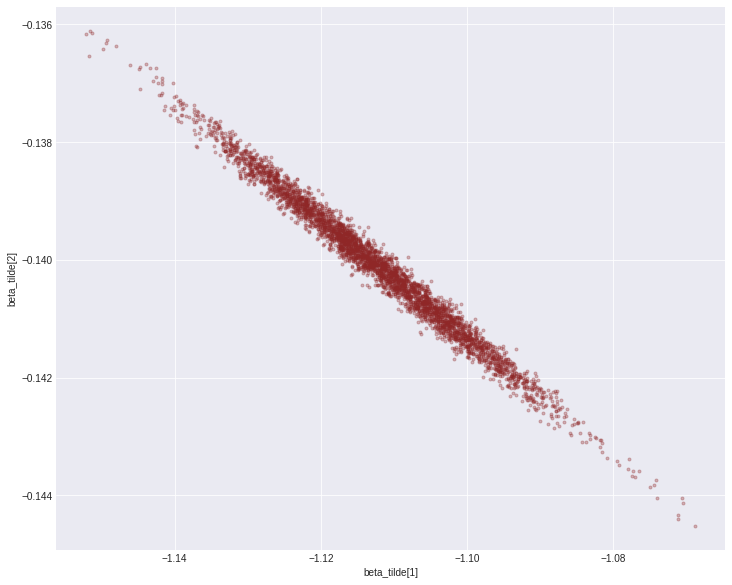

In [28]:
partition = partition_div(qr_fit)
params = partition[0]
ax = plt.subplot(111)
ax.plot(params['beta_tilde'][:,0], params['beta_tilde'][:,1],'.', color=c_dark,alpha=0.3)
ax.set_ylabel('beta_tilde[2]')
ax.set_xlabel('beta_tilde[1]')

Comfortingly, we also successfully recover the posterior for the nominal slopes,

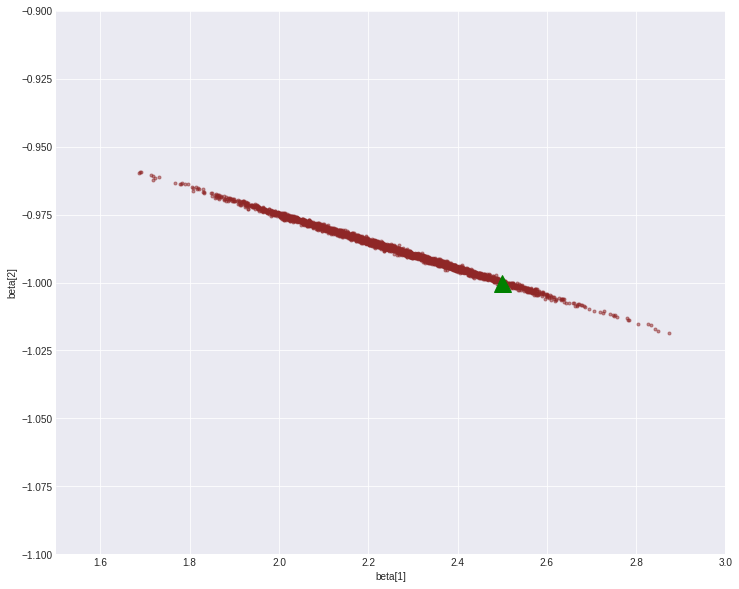

In [29]:
partition = partition_div(qr_fit)
params = partition[0]
ax = plt.subplot(111)
ax.set_xlim([1.5,3])
ax.set_ylim([-1.1,-0.9])
ax.plot(params['beta'][:,0], params['beta'][:,1],'.', color=c_dark,alpha=0.5)
ax.plot(beta[0,0], beta[1,0],'^',color='green', markersize=17)
ax.set_ylabel('beta[2]')
ax.set_xlabel('beta[1]')

### The Importance of Centering Covariates

If the rows of the effective design matrix, $\mathbf{Q}$, are orthogonal, then
why are the transformed slopes nontrivially correlated in the QR regression
posterior?  

One possibility could be the prior we put on the nominal slopes, which implies a
strongly correlated prior for the transformed slopes.  Here, however, the prior
is too weak to have any strong effect on the posterior distribution.  Still,
it's important to keep in mind that the QR decomposition performs best when the
likelihood dominates the prior, either due to sufficiently many data or
sufficiently weak prior information.

The real cause of the correlations in the posterior for the transformed slopes
is that _the covariates are not centered_.  As with any decomposition, the QR
decomposition can fully decorrelate the covariates, and hence the likelihood
and the corresponding posterior, only after the covariates have been centered
around their empirical means.

Our design matrix is readily recentered within Stan itself, although we just as
easily could have done it within R itself.  Keeping in mind that centering the
covariates drastically changes the interpretation of the intercept, we also
should inflate the prior for $\alpha$,

In [30]:
%%stan -f qr_regr_centered.stan

data {
  int<lower=1> N;
  int<lower=1> M;
  matrix[M, N] X;
  vector[N] y;
}

transformed data {
  matrix[M, N] X_centered;
  matrix[N, M] Q;
  matrix[M, M] R;
  matrix[M, M] R_inv;

  for (m in 1:M)
    X_centered[m] = X[m] - mean(X[m]);

  // Compute, thin, and then scale QR decomposition
   Q = qr_Q(X_centered')[, 1:M] * N;
   R = qr_R(X_centered')[1:M, ] / N;
   R_inv = inverse(R);
}

parameters {
  vector[M] beta_tilde;
  real alpha;
  real<lower=0> sigma;
}

transformed parameters {
  vector[M] beta = R_inv * beta_tilde;
}

model {
  beta ~ normal(0, 10);
  alpha ~ normal(0, 100);
  sigma ~ cauchy(0, 10);

  y ~ normal(Q * beta_tilde + alpha, sigma);
}

Using pystan.stanc compiler..
-------------------------------------------------------------------------------
Model compiled successfully. Output stored in _stan_model object.
Type _stan_model in a cell to see a nicely formatted code output in a notebook
     ^^^^^^^^^^^
Access model compile output properties
_stan_model.model_file -> Name of stan_file [qr_regr_centered.stan]
_stan_model.model_name -> Name of stan model [qr_regr_centered_model]
_stan_model.model_code -> Model code [ data {   int<lower= ....]


In [31]:
qr_model = pystan.StanModel(file='qr_regr_centered.stan')
qr_fit = qr_model.sampling(data=data, seed=44)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_9d7eabde2c2a0ff6e9549148300792b3 NOW.


In [32]:
qr_fit

Inference for Stan model: anon_model_9d7eabde2c2a0ff6e9549148300792b3.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

                mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
beta_tilde[0]  -0.25  2.5e-6 1.6e-4  -0.25  -0.25  -0.25  -0.25  -0.25   4000    nan
beta_tilde[1]  -0.02  2.5e-6 1.6e-4  -0.02  -0.02  -0.02  -0.02  -0.02   4000    nan
alpha         -76.32  2.9e-4   0.01 -76.34 -76.33 -76.32 -76.31  -76.3   1432    1.0
sigma           0.79  2.2e-4 7.9e-3   0.78   0.79   0.79    0.8   0.81   1265    1.0
beta[0]         2.26  2.5e-3   0.16   1.94   2.15   2.26   2.37   2.56   4000    1.0
beta[1]        -0.99  1.2e-4 7.9e-3   -1.0  -0.99  -0.99  -0.98  -0.97   4000    1.0
lp__           -1344    0.03   1.36  -1348  -1345  -1344  -1343  -1342   1515    1.0

Samples were drawn using NUTS at Mon Sep 11 20:30:39 2017.
For each parameter, n_eff is a crude measure of effective sample size,


BUG ALERT? : Rhat is __nan__ for beta_tilde but it doesn't seem to affect the results/analysis (cannot reproduce in R). Is this related to https://github.com/stan-dev/pystan/issues/133

In [33]:
check_treedepth(qr_fit)

0 of 4000 iterations saturated the maximum tree depth of 10 (0.0%)


In [34]:
check_energy(qr_fit)
check_div(qr_fit)

0.0 of 4000 iterations ended with a divergence (0.0%)


In [35]:
n_gradients = [np.sum(qr_fit.get_sampler_params(inc_warmup=False)[i]['n_leapfrog__']) for i in range(4)]
n_gradients

[38600.0, 35824.0, 33982.0, 40492.0]

In [36]:
sum(n_gradients)

148898.0

Not only has the effective sample size has drastically increased, the fit
requires only a tenth of the gradient evaluations needed by the naive
regression,


With the improved effective sample size and reduced computational cost, the
centered QR decomposition achieves a 20 fold increase in performance!

All of this is due to the now isotropic posterior for the transformed slopes,

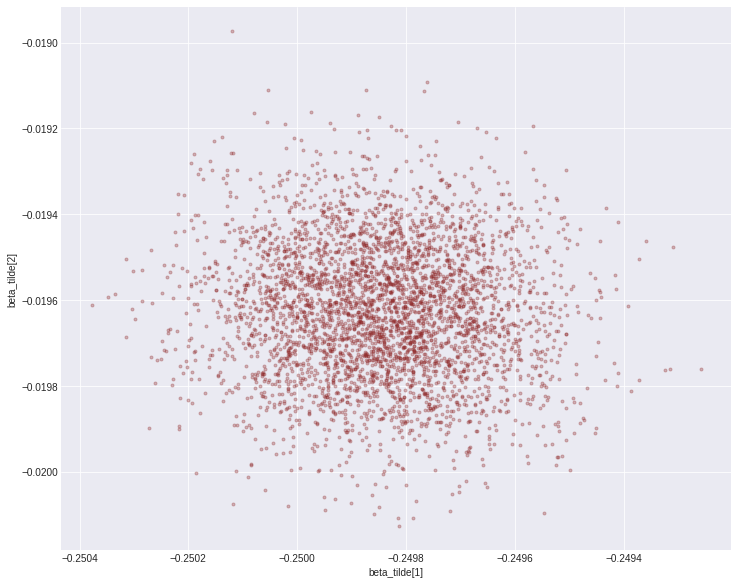

In [37]:
partition = partition_div(qr_fit)
params = partition[0]
ax = plt.subplot(111)
ax.plot(params['beta_tilde'][:,0], params['beta_tilde'][:,1],'.', color=c_dark,alpha=0.3)
ax.set_ylabel('beta_tilde[2]')
ax.set_xlabel('beta_tilde[1]')

While the posterior for the new intercept is expectedly different, the posterior for the nominal slopes remains the same,

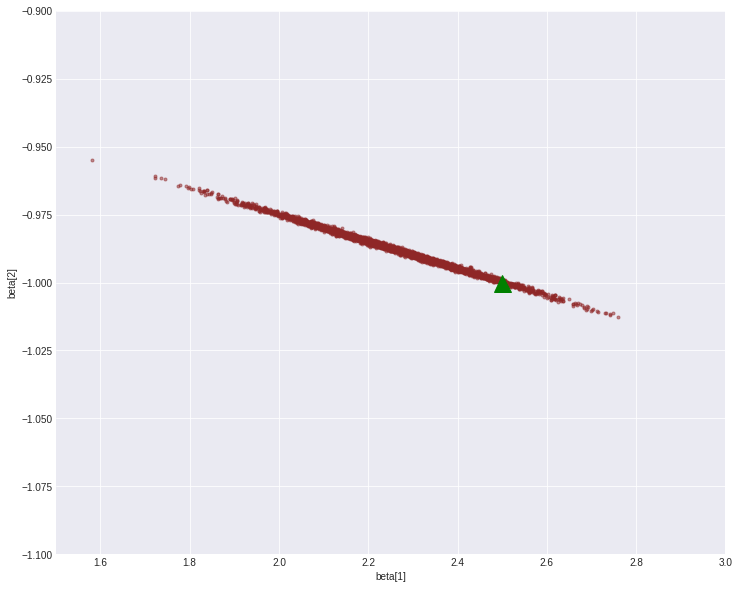

In [38]:
partition = partition_div(qr_fit)
params = partition[0]
ax = plt.subplot(111)
ax.set_xlim([1.5,3])
ax.set_ylim([-1.1,-0.9])
ax.plot(params['beta'][:,0], params['beta'][:,1],'.', color=c_dark,alpha=0.5)
ax.plot(beta[0,0], beta[1,0],'^',color='green', markersize=17)
ax.set_ylabel('beta[2]')
ax.set_xlabel('beta[1]')

A common feature of regression models, centering not only improves the
interpretability of the model but also proves critical to achieving optimal
computational performance.  

## Conclusion

The QR decomposition is a straightforward technique that can drastically improve
the performance of regression with not only linear models but also general
linear models.  Given its ease of use and strong potential for improvement it
should be a ready tool in any modeler's toolbox.

## Acknowledgements

The exact implementation used here was cribbed from the discussion of QR
decomposition in the Stan manual written by Ben Goodrich, who also originally
introduced the technique into the Stan ecosystem.

#### Licenses
Python Code used in this notebook is Copyright(2017) Aravind S. Released under BSD-3 clause license

Original Code: Copyright (2017) Michael Betancourt. Released under the BSD 3-clause license.

Original Text: Copyright (2017) Michael Betancourt. Released under the the CC BY-NC 4.0 license.

## Platform

In [39]:
# conda install numpy scipy matplotlib jupyter gcc
# pip install pystan
# pip install git+https://github.com/Arvinds-ds/stanmagic.git
import matplotlib
print('Tested on Python 2.7,3.6')
print("Numpy Version : ", np.__version__)
print("Scipy Version : ", scipy.__version__)
print("Matplotlib Version: ", matplotlib.__version__)
print("pystan version", pystan.__version__)
print('stanmagic extension 0.0.2')

Tested on Python 2.7,3.6
Numpy Version :  1.13.1
Scipy Version :  0.19.1
Matplotlib Version:  2.0.2
pystan version 2.16.0.0
stanmagic extension 0.0.2


In [40]:
assert True